One of the issues encountered while working on 'Accident area alert notifications' was that there were too many accident hotspots and our app would trigger multiple alerts causing annoyance to the user. <br>
To mitigate, we plan to generate clusters from the dataset so that we can club a bunch of accident spots into one cluster and reduce the frequency of alert notifications.


<b>Required files</b> - <br>
1) Crashes_Last_Five_Years.csv<br>
from 
<a href="https://discover.data.vic.gov.au/dataset/crash-data-extract/resource/02cc0444-aa72-4aec-9575-fabb675a9213">Crash Data Last 5 years</a>
<br><br>
2) ACCIDENT_LOCATION.csv from ACCIDENT.zip<br>
3) NODE_CSV from ACCIDENT.zip from ACCIDENT.zip<br>
from
<a href="https://discover.data.vic.gov.au/dataset/crashes-last-five-years1">Crash Data Extract</a>
  


Keep all the files in the same directory

#  1. Getting the data ready

## (i) Import libraries

In [402]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
import folium
from shapely.geometry import MultiPoint
%matplotlib inline

## (ii) Load Data

In [403]:
df = pd.read_csv('Crashes_Last_Five_Years.csv')
df.columns
#filter only Rural rows
df=df[df['STAT_DIV_NAME'] == 'Country']
#filter out unnecesary columns
df.drop(['X', 'Y', 'OBJECTID', 'ABS_CODE', 'ACCIDENT_STATUS',
       'ACCIDENT_DATE', 'ACCIDENT_TIME', 'ALCOHOLTIME', 'ACCIDENT_TYPE',
       'DAY_OF_WEEK', 'DCA_CODE', 'HIT_RUN_FLAG', 'LIGHT_CONDITION',
       'POLICE_ATTEND', 'ROAD_GEOMETRY', 'SEVERITY', 'SPEED_ZONE',
       'RUN_OFFROAD', 'NODE_ID', 'NODE_TYPE',
       'REGION_NAME', 'VICGRID_X', 'VICGRID_Y', 'TOTAL_PERSONS',
       'INJ_OR_FATAL', 'FATALITY', 'SERIOUSINJURY', 'OTHERINJURY',
       'NONINJURED', 'MALES', 'FEMALES', 'BICYCLIST', 'PASSENGER', 'DRIVER',
       'PEDESTRIAN', 'PILLION', 'MOTORIST', 'UNKNOWN', 'PED_CYCLIST_5_12',
       'PED_CYCLIST_13_18', 'OLD_PEDESTRIAN', 'OLD_DRIVER', 'YOUNG_DRIVER',
       'ALCOHOL_RELATED', 'UNLICENCSED', 'NO_OF_VEHICLES', 'HEAVYVEHICLE',
       'PASSENGERVEHICLE', 'MOTORCYCLE', 'PUBLICVEHICLE', 'DEG_URBAN_NAME',
       'DEG_URBAN_ALL', 'LGA_NAME_ALL', 'REGION_NAME_ALL', 'SRNS', 'SRNS_ALL',
       'RMA', 'RMA_ALL', 'DIVIDED', 'DIVIDED_ALL', 'STAT_DIV_NAME'], axis=1, inplace=True)
#get roadname
#Import ACCIDENT_LOCATION.csv, merge with above dataset
ACCIDENT_LOCATION =  pd.read_csv('ACCIDENT_LOCATION.csv', usecols=['ACCIDENT_NO','ROAD_NAME', 'ROAD_TYPE'])
df1 = pd.merge(df, ACCIDENT_LOCATION, on = "ACCIDENT_NO")
#concatenate ROAD_NAME and ROAD_TYPE
#df1['ROAD'] = df1['ROAD_NAME'] + " " + df1['ROAD_TYPE']
#df1['ROAD'] = df1['ROAD_NAME'] + " " + df1['ROAD_TYPE']
#df1.drop(['ROAD_NAME','ROAD_TYPE'], axis=1, inplace=True)
df1.head()
df1.to_csv('df1.csv', encoding = 'utf-8')
df1.shape

(21650, 6)

# 2. The main part where we cluster

In [404]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088
# represent points consistently as (lat, lon)
coords = df[['LATITUDE', 'LONGITUDE']].values

# define epsilon as 1.5 kilometers, converted to radians for use by haversine
epsilon = 1.5 / kms_per_radian

The scikit-learn DBSCAN haversine distance metric requires data in the form of [latitude, longitude] and both inputs and outputs are in units of radians.

## (i) Compute DBSCAN

   eps is the physical distance from each point that forms its neighborhood
   
   min_samples is the min cluster size, otherwise it's noise - set to 1 so we get no noise

Extract the lat, lon columns into a numpy matrix of coordinates, then convert to radians when you call fit, for use by scikit-learn's haversine metric.


In [405]:
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

print('Clustered' , len(df), 'points down to' ,num_clusters)

Clustered 21651 points down to 4822


In [406]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

## (ii) Find the point in each cluster that is closest to its centroid

This returns one representative point from each cluster. 

First get the lat,lon coordinates of the cluster's centroid (shapely represents the first coordinate in the tuple as x and the second as y, so lat is x and lon is y here). 

Then find the member of the cluster with the smallest great circle distance to the centroid.


In [407]:
#function to get the center of each cluster
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)

In [408]:
#function to get the radius of each cluster
def get_radius(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    AllRadius = []
    for point in cluster:
        AllRadius.append(great_circle(point, centroid))
    return max(AllRadius)
    
radius1 = clusters.map(get_radius)

In [409]:
#function to get the Number of Accidents in each cluster
def get_magnitude(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m) 
    return len(cluster)
NumberOfAccidents1 = clusters.map(get_magnitude)

In [410]:
#converting radius and Number of accidents to dataframe and giving column names
NumberOfAccidents1.to_frame()
radius1.to_frame()
radius = pd.DataFrame({'RADIUS': radius1})
NumberOfAccidents = pd.DataFrame({'NUMBER OF ACCIDENTS': NumberOfAccidents1})

# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'LONGITUDE':lons, 'LATITUDE':lats})
rep_points.tail()

,LONGITUDE,LATITUDE
4817,145.57880,-38.55856
4818,143.08623,-38.58432
4819,146.63874,-36.02781
4820,143.18308,-36.68530
4821,142.52249,-37.88451


## (iii) Create a dataframe of Centroids 

In [411]:
rs = rep_points.apply(lambda row: df[(df['LATITUDE']==row['LATITUDE']) & (df['LONGITUDE']==row['LONGITUDE'])].iloc[0], axis=1)
#concatenating radius
rs = pd.concat([rs, radius], axis=1)
#concatenating Number Of Accidents
rs = pd.concat([rs, NumberOfAccidents], axis=1)

In [412]:
rs2=rs
rs2 = pd.merge(rs1, ACCIDENT_LOCATION, on = 'ACCIDENT_NO')
#Capitalise the first letter of ROAD_TYPE
rs2['ROAD_TYPE'] = rs2.ROAD_TYPE.str.capitalize()
#Capitalise the first letter of ROAD_NAME
rs2['ROAD_NAME'] = rs2.ROAD_NAME.str.capitalize()
rs2 = rs2[~rs2['ACCIDENT_NO'].isin(['T20170010762', 'T20170008255', 'T20170001850', 'T20170005681', 'T20170011114', 'T20170013730', 'T20170013473'])]
rs3 = rs2
rs3.head()

,ACCIDENT_NO,LONGITUDE,LATITUDE,LGA_NAME,RADIUS,NUMBER OF ACCIDENTS,ROAD_NAME,ROAD_TYPE
0,T20130026788,145.94466,-36.54020,BENALLA,1.085796355342465 km,5,Goomalibee,Road
1,T20130026801,144.17079,-36.91563,BENDIGO,0.0 km,1,Hokins,Road
2,T20190003224,144.35753,-38.14280,GEELONG,24.431690857318188 km,2533,Smythe,Street
3,T20160018735,146.38227,-38.21956,LATROBE,28.379573887890366 km,739,Toners,Lane
4,T20130016539,144.06177,-37.10660,MOUNT ALEXANDER,1.609134902429938 km,6,Pyrenees,Highway


In [413]:
#merge the above with NODE.csv to get postcode location for each accident spot
NODE = pd.read_csv(r'NODE.csv', encoding = 'utf-8')
rs3 = pd.merge(rs3, NODE, on = 'ACCIDENT_NO')
rs3.columns

Index(['ACCIDENT_NO', 'LONGITUDE', 'LATITUDE', 'LGA_NAME_x', 'RADIUS',
       'NUMBER OF ACCIDENTS', 'ROAD_NAME', 'ROAD_TYPE', 'NODE_ID', 'NODE_TYPE',
       'AMG_X', 'AMG_Y', 'LGA_NAME_y', 'Lga Name All', 'Region Name',
       'Deg Urban Name', 'Lat', 'Long', 'Postcode No'],
      dtype='object')

In [414]:
#drop unnecessary columns
rs3.drop(['ACCIDENT_NO'],axis=1, inplace=True)
rs3.drop(['NODE_ID'],axis=1, inplace=True)
rs3.drop(['NODE_TYPE'],axis=1, inplace=True)
rs3.drop(['AMG_X'],axis=1, inplace=True)
rs3.drop(['AMG_Y'],axis=1, inplace=True)
rs3.drop(['LGA_NAME_y'],axis=1, inplace=True)
rs3.drop(['Lga Name All'],axis=1, inplace=True)
rs3.drop(['Deg Urban Name'],axis=1, inplace=True)
rs3.drop(['Lat'],axis=1, inplace=True)
rs3.drop(['Long'],axis=1, inplace=True)
rs3.drop(['Region Name'],axis=1, inplace=True)

In [415]:
rs3.head()
#rename the columns 
rs4 = rs3.rename(columns={'LONGITUDE': 'Longitude', 'LATITUDE': 'Latitude', 'LGA_NAME_x': 'LGA', 'RADIUS': 'RadiusInKM', 'NUMBER OF ACCIDENTS': 'AccidentCount', 'ROAD_NAME': 'RoadName', 'ROAD_TYPE': 'RoadType' , 'Postcode No': 'PostcodeNo'})
rs4.head()

,Longitude,Latitude,LGA,RadiusInKM,AccidentCount,RoadName,RoadType,PostcodeNo
0,145.94466,-36.54020,BENALLA,1.085796355342465 km,5,Goomalibee,Road,3672
1,144.17079,-36.91563,BENDIGO,0.0 km,1,Hokins,Road,3453
2,144.35753,-38.14280,GEELONG,24.431690857318188 km,2533,Smythe,Street,3220
3,146.38227,-38.21956,LATROBE,28.379573887890366 km,739,Toners,Lane,3840
4,144.06177,-37.10660,MOUNT ALEXANDER,1.609134902429938 km,6,Pyrenees,Highway,3462


In [416]:
#Round off radius to 2 decimal places
rs4['RadiusInKM'] = rs4['RadiusInKM'].astype('str') 
rs4.dtypes
rs4['RadiusInKM'] = rs4['RadiusInKM'].map(lambda x: str(x)[:-3])
rs4['RadiusInKM'] = rs4['RadiusInKM'].astype(str).astype(float)
rs4.head()
rs4.dtypes
rs4['RadiusInKM'] = rs4['RadiusInKM'].round(2)
rs4.head()

,Longitude,Latitude,LGA,RadiusInKM,AccidentCount,RoadName,RoadType,PostcodeNo
0,145.94466,-36.54020,BENALLA,1.09,5,Goomalibee,Road,3672
1,144.17079,-36.91563,BENDIGO,0.00,1,Hokins,Road,3453
2,144.35753,-38.14280,GEELONG,24.43,2533,Smythe,Street,3220
3,146.38227,-38.21956,LATROBE,28.38,739,Toners,Lane,3840
4,144.06177,-37.10660,MOUNT ALEXANDER,1.61,6,Pyrenees,Highway,3462


In [419]:
#write to csv
rs4.to_csv('AccidentCluster', encoding = 'utf-8')

## (iv) Plotting the full dataset 21k points vs 4.8k clusters

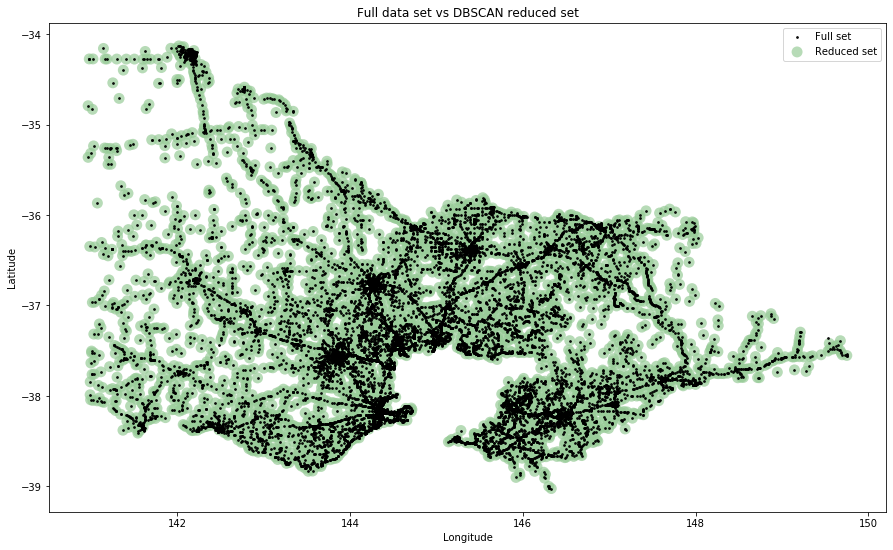

In [417]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[15, 9])
rs_scatter = ax.scatter(rs4['Longitude'], rs4['Latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['LONGITUDE'], df['LATITUDE'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()